# Initial test with denoising autoencoders

In [1]:
import configparser
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

# import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, quantile_transform
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
config = configparser.RawConfigParser()
config.read("Config.properties")

['Config.properties']

In [3]:
wavelengths_path = config.get("path_variables", "wavelengthspath")
datapath = config.get("path_variables", "datapath")

In [4]:
wavelengths = pd.read_csv(wavelengths_path, header=None).iloc[0].values[:-1]

In [5]:
def get_csv_files(input_folder):
    return [
        os.path.join(input_folder, f)
        for f in os.listdir(input_folder)
        if (os.path.isfile(os.path.join(input_folder, f)) and f.endswith(".csv"))
    ]

In [6]:
reddening_files = get_csv_files(datapath)

In [7]:
def select_sources(files, percentage=0.5, index_col=None):
    result_df = pd.DataFrame()
    for f in files:
        curr_df = pd.read_csv(f)
        curr_els = len(curr_df)
        random_numbers = random.sample(
            range(0, curr_els), int(np.ceil(curr_els * percentage))
        )

        selected_df = curr_df[curr_df.index.isin(random_numbers)]
        if index_col and index_col in selected_df.columns:
            selected_df = selected_df.set_index(index_col)
        result_df = pd.concat([result_df, selected_df])
        break
    return selected_df

In [8]:
files_to_select = [reddening_files[0]]

In [9]:
res_df = select_sources(files_to_select, index_col="source_id", percentage=0.05)

In [10]:
res_df = res_df.dropna()
res_df = res_df[~res_df["redden_spectra"].str.contains("inf") == True]
res_df = res_df[~res_df["original_spectra"].str.contains("inf") == True]

In [11]:
def string_to_float_list(input_string):
    data = input_string.replace("(", "")
    data = data.replace(")", "")
    data = data.split(",")
    return np.array(list(map(float, data)))

In [12]:
def apply_gaussian(data, sigma=1):
    from scipy.ndimage import gaussian_filter1d

    gaussian_data = []
    smooth_data = []
    for spectrum in data:
        smooth_spectrum = gaussian_filter1d(spectrum, sigma=sigma)
        result_spectrum = spectrum / smooth_spectrum
        gaussian_data.append(list(result_spectrum))
        smooth_data.append(list(smooth_spectrum))
    return gaussian_data, smooth_data

In [13]:
def min_max_scaler(data):
    scaled_data = []
    for datum in data:
        scaled_datum = (datum - min(datum)) / (max(datum) - min(datum))
        scaled_data.append(scaled_datum)
    return scaled_data

In [14]:
def split_train_test(data_df, normalize=False, save_idx=False, sigma=None):
    indexes = data_df.index.tolist()
    train_idx, test_idx = train_test_split(indexes)
    train_idx.sort()
    test_idx.sort()

    data_df = data_df.sort_index()
    train_data = data_df[data_df.index.isin(train_idx)]
    test_data = data_df[data_df.index.isin(test_idx)]

    train_noisy_values = train_data["redden_spectra"].to_numpy()
    train_noisy_values = np.array([string_to_float_list(x) for x in train_noisy_values])

    train_values = train_data["original_spectra"]
    train_values = np.array([string_to_float_list(x) for x in train_values])

    test_noisy_values = test_data["redden_spectra"]
    test_noisy_values = np.array([string_to_float_list(x) for x in test_noisy_values])

    test_values = test_data["original_spectra"]
    test_values = np.array([string_to_float_list(x) for x in test_values])

    if normalize:
        # train_noisy_values = [x / np.mean(x) for x in train_noisy_values]
        # train_values = [x / np.mean(x) for x in train_values]
        # test_noisy_values = [x / np.mean(x) for x in test_noisy_values]
        # test_values = [x / np.mean(x) for x in test_values]
        train_noisy_values = min_max_scaler(train_noisy_values)
        train_values = min_max_scaler(train_values)
        test_noisy_values = min_max_scaler(test_noisy_values)
        test_values = min_max_scaler(test_values)

    elif sigma:
        train_noisy_values = apply_gaussian(train_noisy_values, sigma)
        train_values = apply_gaussian(train_values, sigma)
        test_noisy_values = apply_gaussian(test_noisy_values, sigma)
        test_values = apply_gaussian(test_values, sigma)

    if not save_idx:
        return train_noisy_values, train_values, test_noisy_values, test_values
    return (
        train_noisy_values,
        train_values,
        test_noisy_values,
        test_values,
        train_idx,
        test_idx,
    )

In [15]:
# x_train_noisy, x_train, x_test_noisy, x_test = split_train_test(res_df, normalize=True)
x_train_noisy, x_train, x_test_noisy, x_test, train_idx, test_idx = split_train_test(
    res_df, normalize=True, save_idx=True
)

[]

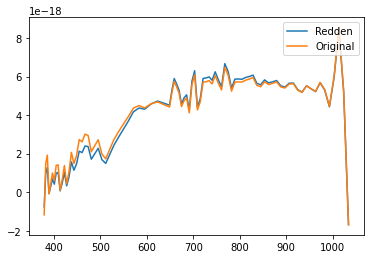

In [17]:
current_idx = train_idx[0]
original_spectra = string_to_float_list(res_df.loc[current_idx, "original_spectra"])
redden_spectra = string_to_float_list(res_df.loc[current_idx, "redden_spectra"])

plt.plot(wavelengths, redden_spectra, label="Redden")
plt.plot(wavelengths, original_spectra, label="Original")
plt.legend(loc="upper right")
plt.plot()

In [18]:
class Autoencoder(Model):
    def __init__(self, latent_dim=24):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = tf.keras.Sequential(
            [
                layers.Dense(87, activation="relu"),
                layers.Dense(32, activation="relu"),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                layers.Dense(32, activation="relu"),
                layers.Dense(87, activation="relu"),                
            ]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [19]:
autoencoder = Autoencoder()
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [ ]:
result = autoencoder.fit(
    x_train_noisy,
    x_train,
    epochs=20,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

In [ ]:
plt.plot(result.history["loss"], label="Training Loss")
plt.plot(result.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
predict_result = autoencoder.predict(x_test_noisy)

In [ ]:
plt_idx = 1
plt.plot(predict_result[plt_idx])

In [ ]:
curr_idx = 10
plt.plot(wavelengths, x_train_noisy[curr_idx])
plt.plot(wavelengths, x_train[curr_idx])

In [ ]:
plt.plot(x_test_noisy[plt_idx], label='noisy')

In [ ]:
plt.plot(x_test[plt_idx], label='original')